## İvme Ölçer ve CNN kullanarak Aktivite Tanımlama

### Veri Seti Linki: https://www.cis.fordham.edu/wisdm/dataset.php
### Veri Setini Kullanarak Yapılmış Çalışma: https://github.com/laxmimerit/Human-Activity-Recognition-Using-Accelerometer-Data-and-CNN

#### Bu dateseti Wireless Sensor Data Mining (WISDM) Lab tarafından yayınlanmıştır. Örnek veri yapısı aşağıda ki gibidir.

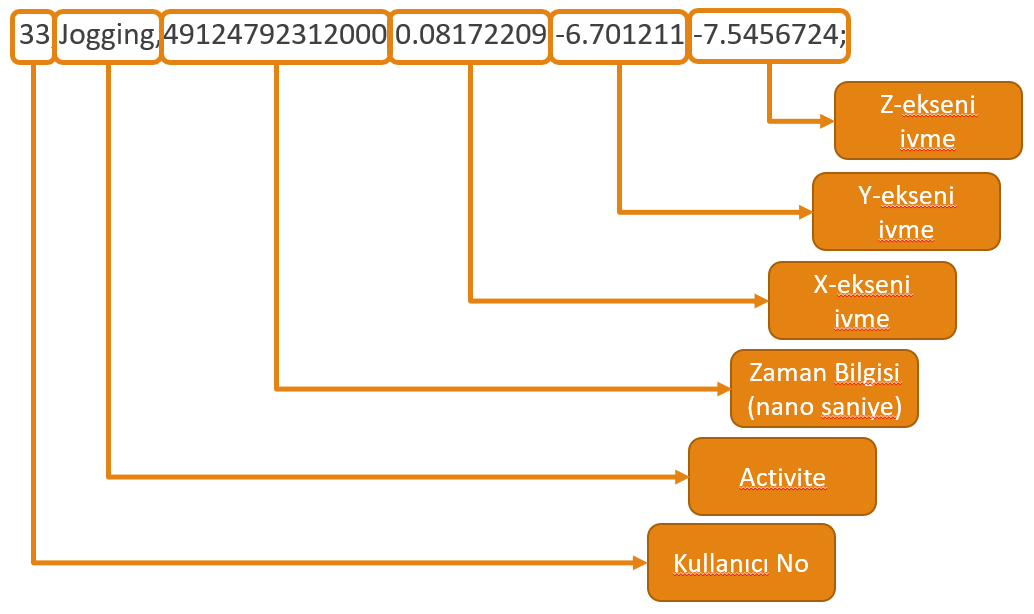

In [10]:
from IPython import display
display.Image("./Images/veri_yapisi.PNG")

#### Aktiviteler: Yürüme, Koşma, Oturma, Ayakta Bekleme, Üst Kata Çıkma, Alt Kata İnme

#### İvme ölçer verileri Android tabanlı bir akıllı telefonun ivme ölçer sensörü kullanılarak 20 Hz de örneklenmiştir. Ancak bu veriler laboratuvar şartları altında toplanmıştır.

#### Verilerin Dağılımı:
- Yürüme -> 424,400 -> 38.6%,
- Koşma -> 342,177 -> 31.2%,
- Oturma -> 122,869 -> 11.2%,
- Ayakta Bekleme -> 100,427 -> 9.1%,
- Üst Kata Çıkma -> 59,939 -> 5.5%,
- Alt Kata İnme -> 48,395 -> 4.4% 
#### Görüldüğü üzere verilerin dağılımı dengeli değildir. Bu nedenle veri setini kullanarak yapay sinir ağını tasarlayabilmemiz için veri setini öncelikle düzenlememiz gerekmekte.

### Bu çalışmada TensorFlow framework kullanılmıştır. 

In [11]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
print(tf.__version__)

2.6.0-dev20210427


In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

In [15]:
#pd.read_csv('WISDM_ar_v1.1/WISDM_ar_v1.1_raw.txt')  

### Veri seti düzensiz olduğundan bu yöntem ile veri setini okumak istediğimizde hata almaktayız!
#### Örnek düzensiz veri yapısı: (134634. satır) 
- 13,Downstairs,3498732310000,5.13,10.42,4.671779;15,Jogging,328982249000,5.37,-3.36,7.3141265;


#### Veri setini incelediğimizde 6 farklı veri olduğunu, bu verilerin ',' ile ayrıldığını ve veri satırının ';' ile sonlandırıldığını görmekteyiz. Bu parametreler göz önüne alındığında veri setini dosya formatında string işlemleri ile parselleme gerçekleştirebiliriz.

In [16]:
file = open('WISDM_ar_v1.1/WISDM_ar_v1.1_raw.txt')
lines = file.readlines()

processedList = []

for i, line in enumerate(lines):
    try:
        line = line.split(',')
        last = line[5].split(';')[0]
        last = last.strip()
        if last == '':
            break;
        temp = [line[0], line[1], line[2], line[3], line[4], last]
        processedList.append(temp)
    except:
        print('Error at line number', i)

Error at line number 281873
Error at line number 281874
Error at line number 281875


#### 281873, 281874, 281875 numaralı satırlar herhangi bir veri tutmamaktadır (NULL).
#### Şimdi 'list' olarak elde ettiğimiz veri setinin ilk beş verisine bakalım

In [20]:
processedList[0:5]

[['33', 'Jogging', '49105962326000', '-0.6946377', '12.680544', '0.50395286'],
 ['33', 'Jogging', '49106062271000', '5.012288', '11.264028', '0.95342433'],
 ['33', 'Jogging', '49106112167000', '4.903325', '10.882658', '-0.08172209'],
 ['33', 'Jogging', '49106222305000', '-0.61291564', '18.496431', '3.0237172'],
 ['33', 'Jogging', '49106332290000', '-1.1849703', '12.108489', '7.205164']]

#### Pandas Dataframe oluşturalım. Bu sayede veri yapısında ki datalara sütun ekleyerek daha anlaşılabilir olmasını sağlayabiliriz.

In [22]:
columns = ['user', 'activity', 'time', 'x', 'y', 'z']
data = pd.DataFrame(data = processedList, columns=columns)
data.head()

,user,activity,time,x,y,z
0,33,Jogging,49105962326000,-0.6946377,12.680544,0.50395286
1,33,Jogging,49106062271000,5.012288,11.264028,0.95342433
2,33,Jogging,49106112167000,4.903325,10.882658,-0.08172209
3,33,Jogging,49106222305000,-0.61291564,18.496431,3.0237172
4,33,Jogging,49106332290000,-1.1849703,12.108489,7.205164


#### Şimdi satır ve sütun sayısını kontrol edelim

In [23]:
data.shape

(343416, 6)

#### 343416 tane veri satırımız ve her bir satırda 6 farklı verimiz mevcut

In [24]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 343416 entries, 0 to 343415
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   user      343416 non-null  object
 1   activity  343416 non-null  object
 2   time      343416 non-null  object
 3   x         343416 non-null  object
 4   y         343416 non-null  object
 5   z         343416 non-null  object
dtypes: object(6)
memory usage: 15.7+ MB


#### Değişkenler 'object' tipinde, ancak bu veriler üzerinde işlem yapabilmemiz için bu değişkenlerin nümerik olması gerekmekte

#### Data dağılımına tekrar bir göz atalım

In [27]:
data['activity'].value_counts()

Walking       137375
Jogging       129392
Upstairs       35137
Downstairs     33358
Sitting         4599
Standing        3555
Name: activity, dtype: int64

####  Dağılımın şuanda dengesiz. En az veriye sahip olan kategori 'ayakta bekleme'

### Veri setininin dağılımını düzenleyelim

In [28]:
#Öncelikle sensör verilerini 'float' formatına çevirelim
data['x'] = data['x'].astype('float')
data['y'] = data['y'].astype('float')
data['z'] = data['z'].astype('float')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 343416 entries, 0 to 343415
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   user      343416 non-null  object 
 1   activity  343416 non-null  object 
 2   time      343416 non-null  object 
 3   x         343416 non-null  float64
 4   y         343416 non-null  float64
 5   z         343416 non-null  float64
dtypes: float64(3), object(3)
memory usage: 15.7+ MB


#### Veri setini grafiksel inceleyelim ve aktivitelerin davranışlarını gözlemleyelim. Bunun için veri setinin örnekleme frekansını göz önünde bulundurmamız gerekiyor.

In [29]:
Fs = 20
activities = data['activity'].value_counts().index
activities

Index(['Walking', 'Jogging', 'Upstairs', 'Downstairs', 'Sitting', 'Standing'], dtype='object')

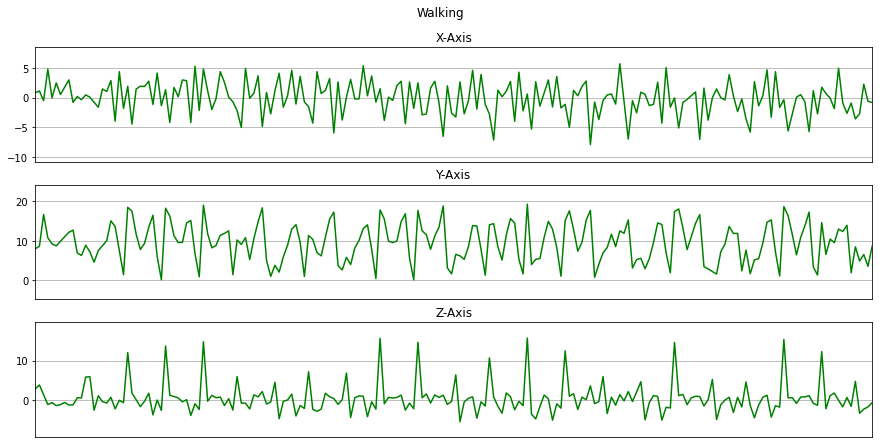

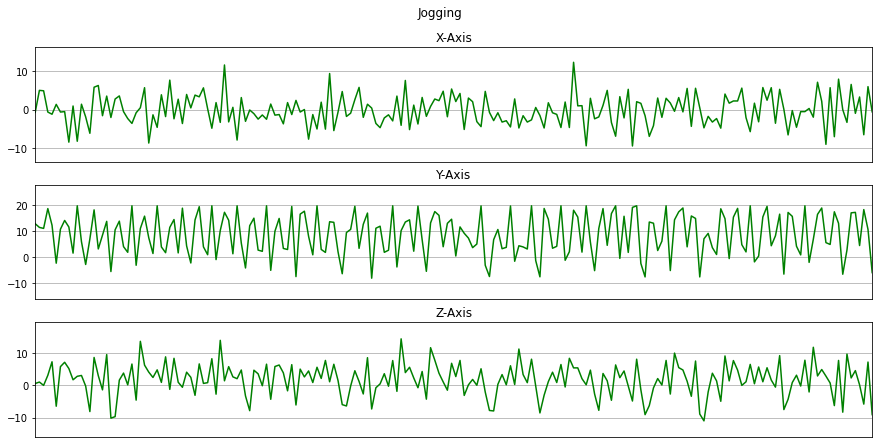

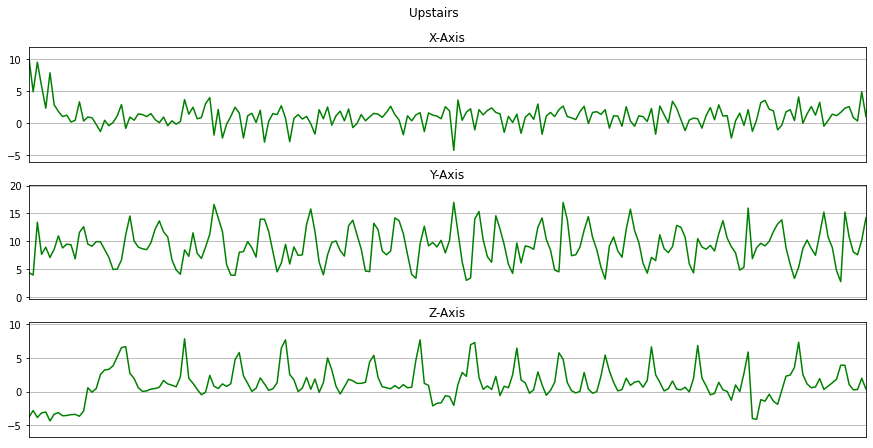

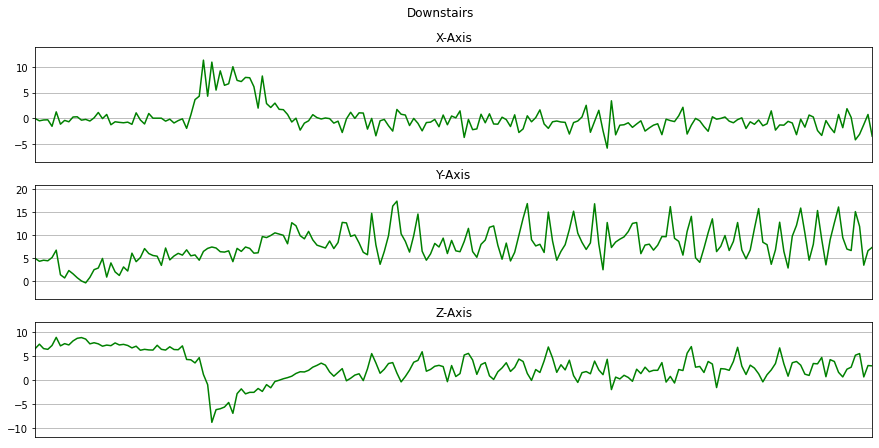

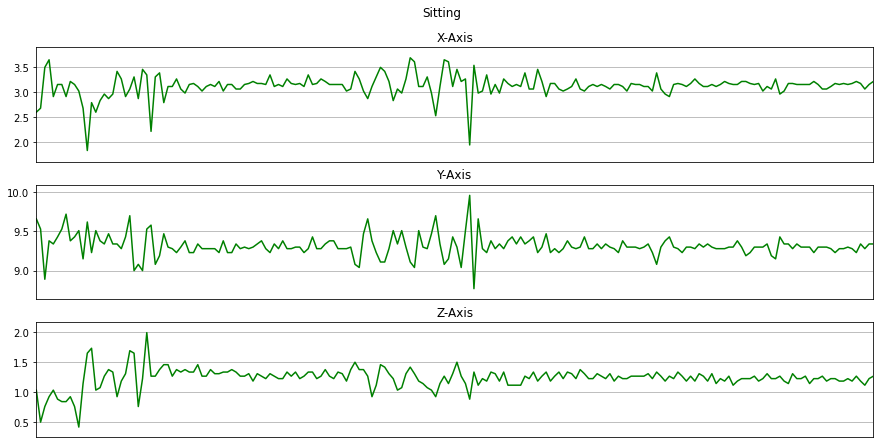

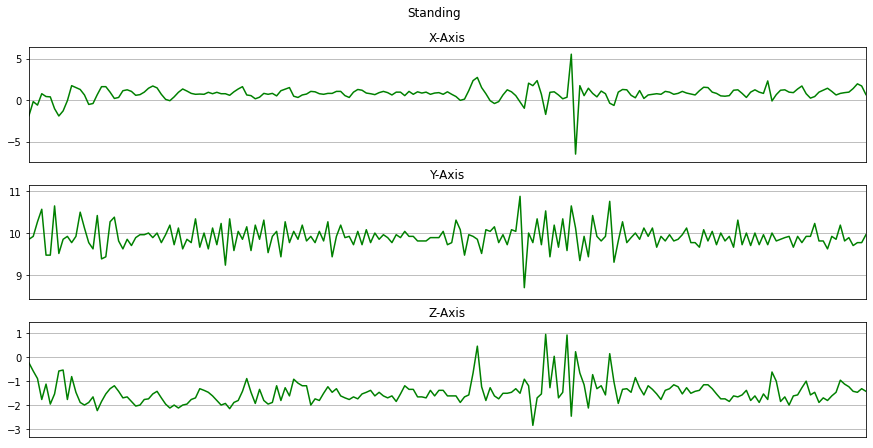

In [30]:
def plot_activity(activity, data):
    fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, figsize=(15,7), sharex=True)
    plot_axis(ax0, data['time'], data['x'], 'X-Axis')
    plot_axis(ax1, data['time'], data['y'], 'Y-Axis')
    plot_axis(ax2, data['time'], data['z'], 'Z-Axis')
    plt.subplots_adjust(hspace=0.2)
    fig.suptitle(activity)
    plt.subplots_adjust(top=0.90)
    plt.show()
    
def plot_axis(ax, x, y, title):
    ax.plot(x, y, 'g')
    ax.set_title(title)
    ax.xaxis.set_visible(False)
    ax.set_ylim([min(y) - np.std(y), max(y) + np.std(y)])
    ax.set_xlim([min(x), max(x)])
    ax.grid(True)
    
for activity in activities:
    data_for_plot = data[(data['activity'] == activity)][:Fs*10]
    plot_activity(activity, data_for_plot)

#### Koşma verisinde çok fazla değişim varken ayakta bekleme verisi daha değişmekte

#### Şimdi 'user' ve 'time' bilgilerini kaldıralım

In [31]:
df = data.drop(['user', 'time'], axis = 1).copy()
df.head()

,activity,x,y,z
0,Jogging,-0.694638,12.680544,0.503953
1,Jogging,5.012288,11.264028,0.953424
2,Jogging,4.903325,10.882658,-0.081722
3,Jogging,-0.612916,18.496431,3.023717
4,Jogging,-1.184970,12.108489,7.205164


#### Minimim örnek sayısına sahip olan aktivite 'Ayakta Bekleme' verisiydi. Şimdi diğer veri sayılarını minimum kuralına göre elde edelim.

In [32]:
Walking = df[df['activity'] == 'Walking'].head(3555).copy()
Jogging = df[df['activity'] == 'Jogging'].head(3555).copy()
Upstairs = df[df['activity'] == 'Upstairs'].head(3555).copy()
Downstairs = df[df['activity'] == 'Downstairs'].head(3555).copy()
Sitting = df[df['activity'] == 'Sitting'].head(3555).copy()
Standing = df[df['activity'] == 'Standing'].copy()

### Dengeli Veri Setimiz

In [33]:
balanced_data = pd.DataFrame()
balanced_data = balanced_data.append([Walking, Jogging, Upstairs, Downstairs, Sitting, Standing])
balanced_data.shape

(21330, 4)

#### 3555*6 = 21330 satır ve 4 sütunumuz mevcut

In [34]:
balanced_data['activity'].value_counts()

Jogging       3555
Walking       3555
Standing      3555
Upstairs      3555
Sitting       3555
Downstairs    3555
Name: activity, dtype: int64

#### Dengeli veri setimizin ilk beş satırı

In [35]:
balanced_data.head()

,activity,x,y,z
597,Walking,0.844462,8.008764,2.792171
598,Walking,1.116869,8.621680,3.786457
599,Walking,-0.503953,16.657684,1.307553
600,Walking,4.794363,10.760075,-1.184970
601,Walking,-0.040861,9.234595,-0.694638


#### Activity türlerimiz string formatında, şimdi bunları kategorik değişkenlere dönüştürmemiz gerekmekte

In [36]:
label = LabelEncoder()
balanced_data['label'] = label.fit_transform(balanced_data['activity'])
balanced_data.head()

,activity,x,y,z,label
597,Walking,0.844462,8.008764,2.792171,5
598,Walking,1.116869,8.621680,3.786457,5
599,Walking,-0.503953,16.657684,1.307553,5
600,Walking,4.794363,10.760075,-1.184970,5
601,Walking,-0.040861,9.234595,-0.694638,5


In [37]:
label.classes_

array(['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs',
       'Walking'], dtype=object)

#### İndis numaralandırması 0 dan başlamakta ve 'Walking' kategorisinin nümerik değeri 5 olarak ayarlandı

#### Veri setininin varyansını standart hale getirelim. Çünkü ivme değerlerinin varyansı her bir eksen için farklılık göstermekte 

In [38]:
x = balanced_data[['x', 'y', 'z']]
y = balanced_data['label']

scaler = StandardScaler()
X = scaler.fit_transform(x)

scaled_X = pd.DataFrame(data=X, columns=['x', 'y', 'z'])
scaled_X['label'] = y.values

scaled_X

,x,y,z,label
0,0.000503,-0.099190,0.337933,5
1,0.073590,0.020386,0.633446,5
2,-0.361275,1.588160,-0.103312,5
3,1.060258,0.437573,-0.844119,5
4,-0.237028,0.139962,-0.698386,5
...,...,...,...,...
21325,-0.470217,0.178084,0.261019,3
21326,-0.542658,0.193692,0.248875,3
21327,-0.628514,0.197593,0.261019,3
21328,-0.781444,0.049322,0.155768,3


### Herbir 4 saniyede çıkarım yapmak için verimizi ayarlayalım

In [39]:
import scipy.stats as stats

In [40]:
Fs = 20
frame_size = Fs*4 #80
#20 örnek * 4 saniye  => 80 örnek
hop_size = Fs * 2

#### 80 örneği 

In [41]:
def get_frames(df, frame_size, hop_size):

    N_FEATURES = 3

    frames = []
    labels = []
    for i in range(0, len(df) - frame_size, hop_size):
        x = df['x'].values[i: i + frame_size]
        y = df['y'].values[i: i + frame_size]
        z = df['z'].values[i: i + frame_size]
        
        # en çok kullanılan aktiviteyi belirle
        label = stats.mode(df['label'][i: i + frame_size])[0][0]
        frames.append([x, y, z])
        labels.append(label)

    # verileri dizi formatına çevirelim
    frames = np.asarray(frames).reshape(-1, frame_size, N_FEATURES)
    labels = np.asarray(labels)

    return frames, labels

X, y = get_frames(scaled_X, frame_size, hop_size)

X.shape, y.shape

((532, 80, 3), (532,))

### Eğitim ve Test verilerini ayrıştıralım 
- Eğitim -> %80
- Test   -> %20

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0, stratify = y)

### 425 örnek eğitim için, 107 örnek test verisi için ayrıldı

In [44]:
X_train.shape, X_test.shape

((425, 80, 3), (107, 80, 3))

In [45]:
X_train[0].shape, X_test[0].shape

((80, 3), (80, 3))

### !Tek bir veriye baktığımızda iki boyutlu olduğunu görmekteyiz. Ancak CNN için üç boyutlu giriş vermemiz gerekmekte. Bunun için dönüşüm gerçekleştirmemiz gerekmekte.

In [46]:
X_train = X_train.reshape(425, 80, 3, 1)
X_test = X_test.reshape(107, 80, 3, 1)

#### CNN için üç boyutlu veri setimiz hazır

In [47]:
X_train[0].shape, X_test[0].shape

((80, 3, 1), (80, 3, 1))

# 2D CNN Model

### Convolutional Neural Network - Evrişimsel Sinir Ağları
#### https://medium.com/@tuncerergin/convolutional-neural-network-convnet-yada-cnn-nedir-nasil-calisir-97a0f5d34cad
- Convolutional Layer: Girdi verisinin özelliklerini algılamak için çeşitli filtreler uygulamaktadır.
ReLu Fonksiyonu f (x) = max (0, x)
- Non-Linearity Layer: Sisteme doğrusal olmayanlığın tanıtılması
- Pooling (Downsampling) Layer: Ağırlık sayısını azaltır ve uygunluğu kontrol eder
- Flatting Layer : Klasik sinir ağı için verileri hazırlar
- Fully-Connected Layer: Sınıflandırmada kullanılan standart sinir ağı

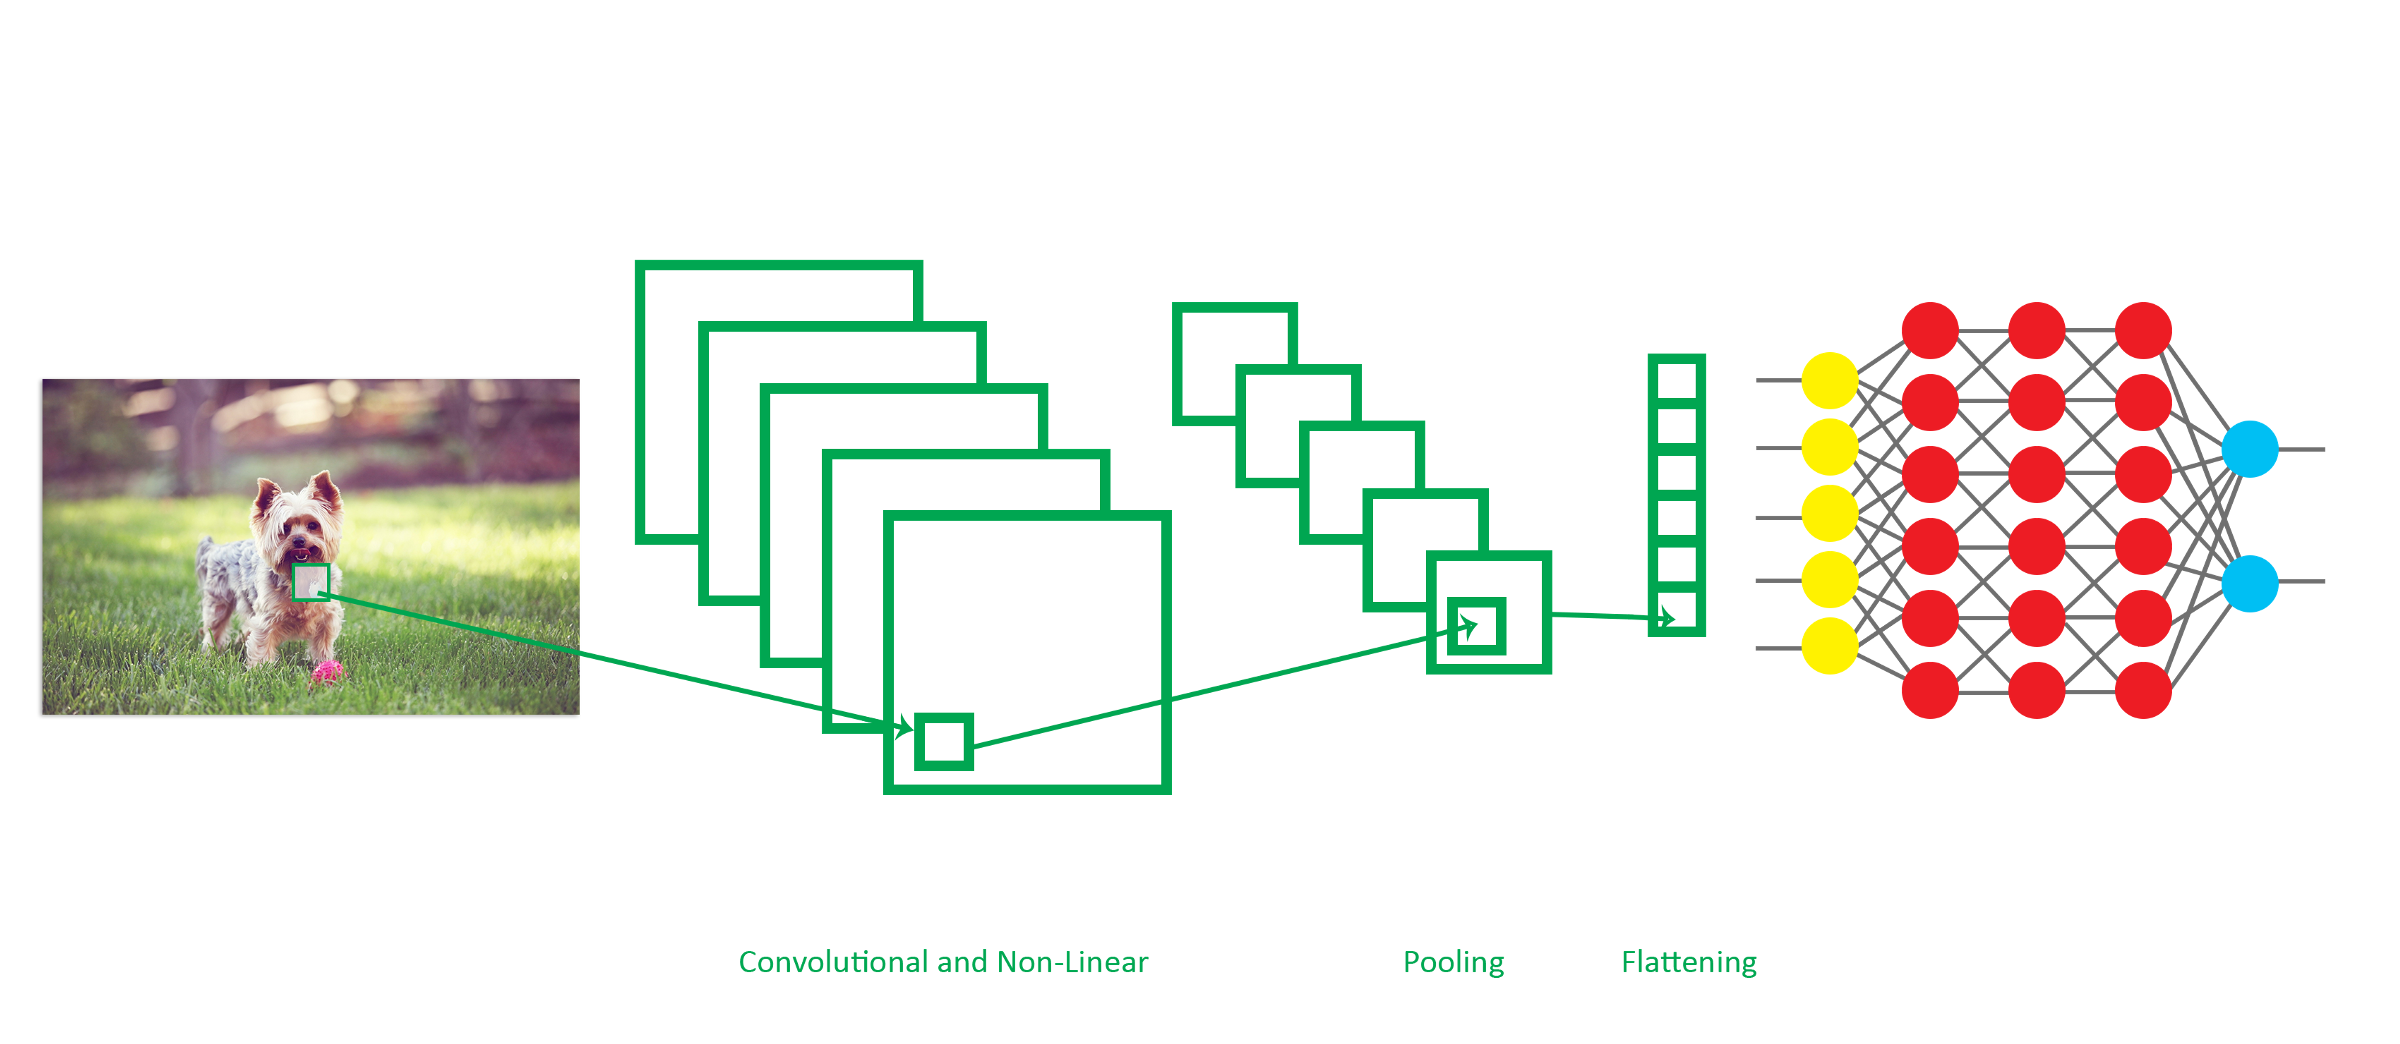

In [54]:
display.Image("./Images/cnn.png")
#https://medium.com/@tuncerergin/convolutional-neural-network-convnet-yada-cnn-nedir-nasil-calisir-97a0f5d34cadÜ

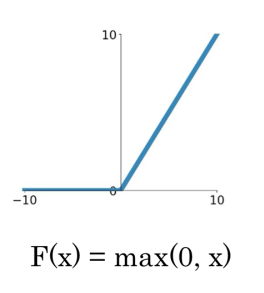

In [55]:
display.Image("./Images/relu.png")
#https://pythondunyasi.com/derin-ogrenme-aktivasyon-fonksiyonlari/

In [74]:
#Sequential Layer -> Sıralı Katman Modeli  
model = Sequential()
#Katmanları .add() ile ekleyelim
model.add(Conv2D(16, (2, 2), activation = 'relu', input_shape = X_train[0].shape))
#Overfitting'i engellemek için ağırlıkların %1'ini düşürelim
#Zayıf bilgilerin unutulması
model.add(Dropout(0.1))

model.add(Conv2D(32, (2, 2), activation='relu'))
model.add(Dropout(0.2))

model.add(Flatten())
#Dense Layer -> Fully Connected Layer olarak da bilinmekte.
#Yani bütün girişleri ve çıkışları birbirine bağlamakta
model.add(Dense(64, activation = 'relu'))
model.add(Dropout(0.5))

#OHE -> 'One-Hot-Encoding'
#Şimdi bizim 6 farklı aktivite türümüz mevcut
#Biz girişe ivme bilgilerini verdiğimizde çıkıştan
#hangi aktivite daha yüksek olasılıkla tahmin edildiyse 1, diğerleri 0 olsun istiyoruz
#Ve 1 olan nöron bize aktiviteyi vermiş olacak
#Bu yüzden aaktivasyon fonksiyonunu softmax olarak çıkış katmanını ekledik
model.add(Dense(6, activation='softmax'))

#### Categorical Cross Entropy vs Sparse Categorical Cross Entropy
https://sanjivgautamofficial.medium.com/categorical-cross-entropy-vs-sparse-categorical-cross-entropy-b6a24de2b7f0

In [75]:
model.compile(optimizer=Adam(learning_rate = 0.001), loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
history = model.fit(X_train, y_train, batch_size=1, epochs = 10, validation_data= (X_test, y_test), verbose=1)

Epoch 1/10
425/425 [==============================] - 2s 3ms/step - loss: 1.3956 - accuracy: 0.4329 - val_loss: 0.6560 - val_accuracy: 0.7944
Epoch 2/10
425/425 [==============================] - 1s 3ms/step - loss: 0.6111 - accuracy: 0.7647 - val_loss: 0.3352 - val_accuracy: 0.8972
Epoch 3/10
425/425 [==============================] - 1s 3ms/step - loss: 0.2652 - accuracy: 0.9035 - val_loss: 0.2431 - val_accuracy: 0.8972
Epoch 4/10
425/425 [==============================] - 1s 3ms/step - loss: 0.1669 - accuracy: 0.9459 - val_loss: 0.2480 - val_accuracy: 0.9159
Epoch 5/10
425/425 [==============================] - 1s 3ms/step - loss: 0.1415 - accuracy: 0.9412 - val_loss: 0.2128 - val_accuracy: 0.9252
Epoch 6/10
425/425 [==============================] - 1s 3ms/step - loss: 0.1077 - accuracy: 0.9671 - val_loss: 0.2481 - val_accuracy: 0.9252
Epoch 7/10
425/425 [==============================] - 1s 3ms/step - loss: 0.0715 - accuracy: 0.9765 - val_loss: 0.1951 - val_accuracy: 0.9533
Epoch 

#### Hata ve Doğruluk Grafikleri

In [58]:
def plot_learningCurve(history, epochs):
  # Plot training & validation accuracy values
  epoch_range = range(1, epochs+1)
  plt.plot(epoch_range, history.history['accuracy'])
  plt.plot(epoch_range, history.history['val_accuracy'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()

  # Plot training & validation loss values
  plt.plot(epoch_range, history.history['loss'])
  plt.plot(epoch_range, history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()

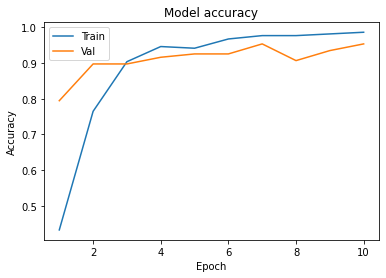

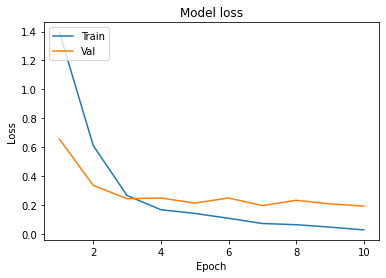

In [76]:
plot_learningCurve(history, 10)

### Confusion Matrix

In [63]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

In [77]:
y_pred = model.predict_classes(X_test)

c:\users\koral\appdata\local\programs\python\python39\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


(<Figure size 504x504 with 1 Axes>,
 <AxesSubplot:xlabel='predicted label', ylabel='true label'>)

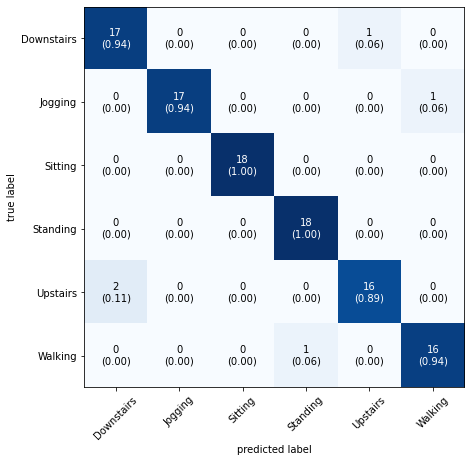

In [78]:
mat = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(conf_mat=mat, class_names=label.classes_, show_normed=True, figsize=(7,7))

In [79]:
model.save_weights('model.h5')

In [80]:
y_test

array([4, 2, 2, 1, 1, 1, 5, 4, 2, 4, 3, 2, 0, 2, 3, 2, 1, 1, 2, 5, 4, 5,
       5, 1, 1, 0, 5, 3, 3, 1, 0, 0, 4, 5, 2, 5, 2, 1, 1, 2, 2, 1, 4, 0,
       4, 0, 2, 3, 3, 3, 2, 4, 5, 0, 4, 3, 3, 4, 3, 0, 0, 1, 1, 0, 1, 2,
       1, 0, 3, 3, 3, 5, 4, 4, 4, 4, 5, 2, 5, 5, 4, 3, 3, 4, 4, 3, 0, 3,
       5, 5, 5, 0, 2, 1, 4, 0, 3, 0, 0, 1, 2, 5, 0, 5, 1, 0, 2])

In [81]:
y_pred

array([4, 2, 2, 1, 1, 1, 5, 4, 2, 4, 3, 2, 0, 2, 3, 2, 1, 1, 2, 5, 4, 5,
       5, 1, 1, 0, 5, 3, 3, 1, 0, 0, 4, 5, 2, 5, 2, 1, 1, 2, 2, 5, 4, 0,
       4, 4, 2, 3, 3, 3, 2, 4, 5, 0, 4, 3, 3, 4, 3, 0, 0, 1, 1, 0, 1, 2,
       1, 0, 3, 3, 3, 5, 4, 4, 4, 0, 5, 2, 3, 5, 4, 3, 3, 4, 4, 3, 0, 3,
       5, 5, 5, 0, 2, 1, 0, 0, 3, 0, 0, 1, 2, 5, 0, 5, 1, 0, 2],
      dtype=int64)

In [83]:
label.classes_

array(['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs',
       'Walking'], dtype=object)